<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/orderml

/content/drive/.shortcut-targets-by-id/1FKl2J9VPA88stIpA_grTLED-Fv9_B7CF/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

chisurface.png  logs/  orderparams.ipynb  OrderPresentation.gslides  test.png


Install non-default packages here.

In [ ]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 2.6MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=12a82834b9739bb4d4d2625c05c4c26e788cf5182e326415b73b2a5d955cbfc6
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.8MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" code.

In [ ]:
class OrderMethods():

    def getData(T, p):
        Jt, Nf, Bk = p
        return OrderMethods.orderparameter(T, 160, .885, 330, Bk)

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        #print t
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

        return xout


    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B

    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
        return Br

    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
        bout=Bk+Nf*br**2
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(OrderMethods.Intensity(t,p))
        return np.array(I)

    def fit(model):
        nllfs = []
        zin = []
        for tns in np.arange(50,200, 5):
            #print("zs", zs)
            model.Tn.value = tns
            model.update()
            schi=model.nllf()
            nllfs.append(schi)
            zin.append(tns)
        plt.scatter(zin, nllfs)
        plt.xlabel("tn in")
        plt.ylabel("chi") 
        plt.show()
        plt.savefig("chisurface")
        plt.close()
        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [15]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym

class OrderEnv(gym.Env): #add gym.env

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = np.array([])
        self.startTn = 150
        self.p = [.885,330,.3]
        self.error = []

        # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        self.action_space = spaces.Discrete(7)
        self.action_options = [1, 5, 10, 15, 20, 25, 30]
        self.curTemp = 3
        self.x = self.startTn

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.Jts = []
        self.Nfs = []
        self.totReward = 0 
        self.info = {}     

    def step(self, action): 
        
        print("stepping: ", self.episodeNum)
        print("ACTION            : ", action)

        self.curTemp += self.action_options[action]
        #self.curTemp = action
        self.curTemp = self.round_to(self.curTemp, 0.5)
        print("curtemp: ", self.curTemp)

        self.steps += 1
        reward = -self.reward_scale
        self.T = np.append(self.T, self.curTemp)
        print("Temperature: ", self.T)
        
        if self.steps > 3:
            self.I = OrderMethods.getData(self.T, self.p)
            print("Intensity: ", self.I)
            self.error= np.sqrt(self.I)
            M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Jt = .2, Nf = 216, Bk = self.p[2]) #, Jt = self.p[0], Nf = self.p[1]
            M.Tn.range(10, 400)
            M.Jt.range(0.4, 2)
            M.Nf.range(100,500)

            self.x, dx, chisq, params = OrderMethods.fit(M)
            self.Nf = self.x[1]
            self.Jt = self.x[0]
            self.x = self.x[2]
            print("ORDER PARAM RESULT (X2):", self.x)
            print("THE JT RESULT {X0}:", self.Jt)
            print("THE NF RESULT {X1}:", self.Nf)

            dx = params[0].dx

            print("chisqds: ", chisq)
            print("BUT ARE WE SURE?:", dx)

            plt.plot(self.T, self.I, 'ro')
            plt.show()
            plt.close()

            # if(action > 0.5):
            #   reward += 1000

            if chisq < 2 :
                  reward += 100

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)
            self.Jts.append(self.Jt)
            self.Nfs.append(self.Nf)

        print("highHIIIIGHHHHHH: ", (340-self.curTemp))
        print("rewaRD:: ", reward)

        self.totReward += reward
        np.append(self.state, self.curTemp)
        delta = abs(340 - self.curTemp)

        if (self.steps > 3 and chisq < 0.05 and dx < 10000000): #less than or equal to?
            print("terminated: excellent conditions")
            terminal = True
            self.log()

        elif (self.curTemp >= 340):
            print("terminated: oveer max temp")
            terminal = True
            self.log()
        elif (self.steps > 100):
            print("terminated: too long")
            terminal = True
            self.log()
        else:
            terminal = False

        return self.state, reward, terminal, self.info


    def reset(self):
        print("reset")
        self.steps = 0
        self.T = np.array([])
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.Jts = []
        self.Nfs = []
        self.totReward = 0
        self.curTemp = 3
        self.state = np.array([self.curTemp])

        return self.state #starting state

    def log(self):
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.chisqds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.transTemps)

        filename = "logs/jt/jtLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.Jts)

        filename = "logs/nf/nfLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.Nfs)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.npy"
        np.savetxt(filename, self.rewards)

    # @property
    # def action_space(self):
    #     return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
    #     # return spaces.Box(low = np.array([self.curTemp + 0.5]), high = np.array([340]))

    @property 
    def observation_space(self):
        return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)


    def round_to(self, n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

In [ ]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [18]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

reset
stepping:  0
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  0
ACTION            :  3
curtemp:  19.0
Temperature:  [ 4. 19.]
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
stepping:  0
ACTION            :  0
curtemp:  20.0
Temperature:  [ 4. 19. 20.]
highHIIIIGHHHHHH:  320.0
rewaRD::  -100
stepping:  0
ACTION            :  0
curtemp:  21.0
Temperature:  [ 4. 19. 20. 21.]
Intensity:  [330.3        330.29887253 330.29779636 330.29595923]


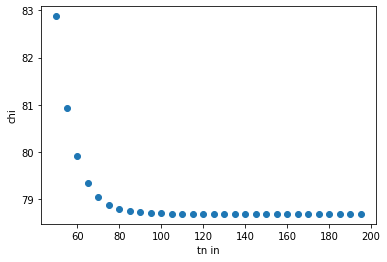

ORDER PARAM RESULT (X2): 270.73196131289365
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 216.00001379264768
chisqds:  157.3799476132247
BUT ARE WE SURE?: 16723702.824649975


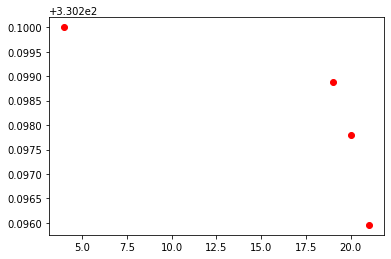

highHIIIIGHHHHHH:  319.0
rewaRD::  -100
stepping:  0
ACTION            :  5
curtemp:  46.0
Temperature:  [ 4. 19. 20. 21. 46.]
Intensity:  [330.3        330.29887253 330.29779636 330.29595923 327.27863264]


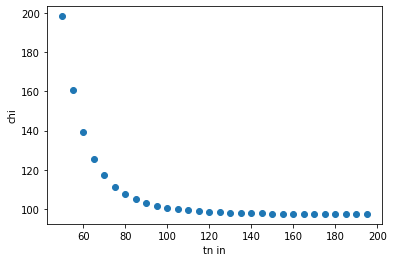

ORDER PARAM RESULT (X2): 291.4579114009886
THE JT RESULT {X0}: 0.4000000108914938
THE NF RESULT {X1}: 222.64830527919278
chisqds:  86.40905381591982
BUT ARE WE SURE?: 28436974024.333927


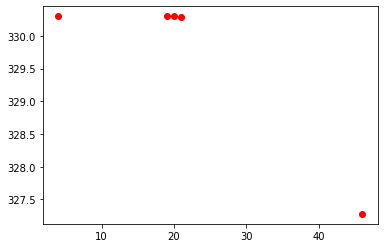

highHIIIIGHHHHHH:  294.0
rewaRD::  -100
stepping:  0
ACTION            :  6
curtemp:  76.0
Temperature:  [ 4. 19. 20. 21. 46. 76.]
Intensity:  [330.3        330.29887253 330.29779636 330.29595923 327.27863264
 299.32155331]


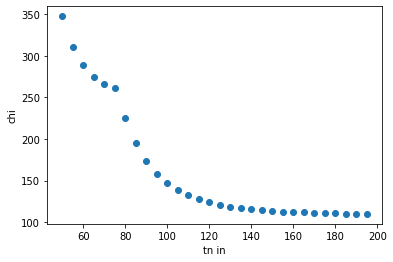

ORDER PARAM RESULT (X2): 221.4872741429583
THE JT RESULT {X0}: 0.4000000524442389
THE NF RESULT {X1}: 223.91723040260595
chisqds:  62.909194043767265
BUT ARE WE SURE?: 373.9613530785683


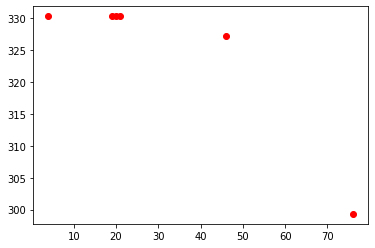

highHIIIIGHHHHHH:  264.0
rewaRD::  -100
stepping:  0
ACTION            :  5
curtemp:  101.0
Temperature:  [  4.  19.  20.  21.  46.  76. 101.]
Intensity:  [330.3        330.29887253 330.29779636 330.29595923 327.27863264
 299.32155331 245.96462596]


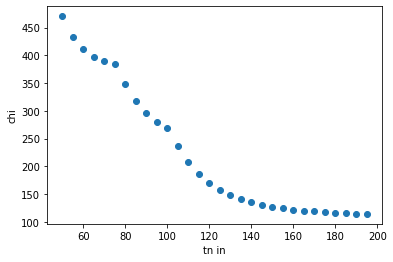

ORDER PARAM RESULT (X2): 203.37285827533304
THE JT RESULT {X0}: 0.40000004160818997
THE NF RESULT {X1}: 222.49948791720533
chisqds:  50.29713662584968
BUT ARE WE SURE?: 9.420966037142854


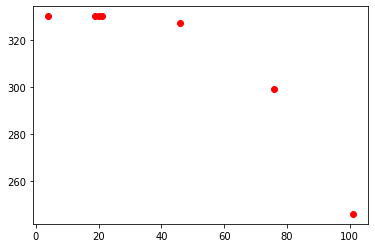

highHIIIIGHHHHHH:  239.0
rewaRD::  -100
stepping:  0
ACTION            :  4
curtemp:  121.0
Temperature:  [  4.  19.  20.  21.  46.  76. 101. 121.]
Intensity:  [330.3        330.29887253 330.29779636 330.29595923 327.27863264
 299.32155331 245.96462596 181.90514965]


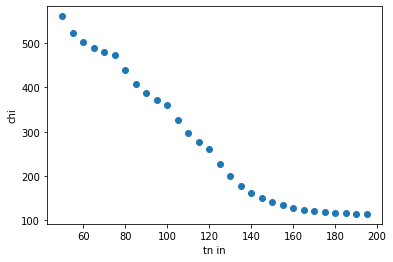

ORDER PARAM RESULT (X2): 198.09784857919811
THE JT RESULT {X0}: 0.40000013348332236
THE NF RESULT {X1}: 225.50518444699026
chisqds:  38.0437962438555
BUT ARE WE SURE?: 3.0961630941573905


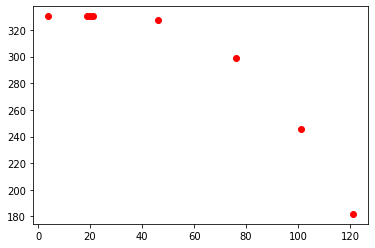

highHIIIIGHHHHHH:  219.0
rewaRD::  -100
stepping:  0
ACTION            :  5
curtemp:  146.0
Temperature:  [  4.  19.  20.  21.  46.  76. 101. 121. 146.]
Intensity:  [330.3        330.29887253 330.29779636 330.29595923 327.27863264
 299.32155331 245.96462596 181.90514965  74.22981172]


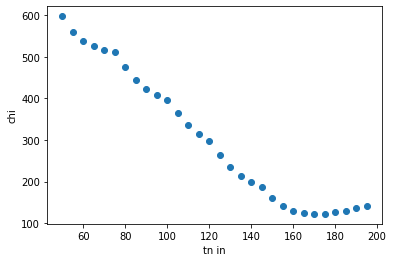

ORDER PARAM RESULT (X2): 159.99999999998533
THE JT RESULT {X0}: 0.8850000000000793
THE NF RESULT {X1}: 329.9999999999998
chisqds:  1.2327256844615282e-23
BUT ARE WE SURE?: 0.4710413425533902


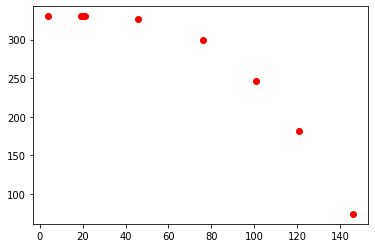

highHIIIIGHHHHHH:  194.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  1
ACTION            :  1
curtemp:  8.0
Temperature:  [8.]
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  1
ACTION            :  4
curtemp:  28.0
Temperature:  [ 8. 28.]
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
stepping:  1
ACTION            :  6
curtemp:  58.0
Temperature:  [ 8. 28. 58.]
highHIIIIGHHHHHH:  282.0
rewaRD::  -100
stepping:  1
ACTION            :  2
curtemp:  68.0
Temperature:  [ 8. 28. 58. 68.]
Intensity:  [330.3        330.21615139 320.37570572 310.38482635]


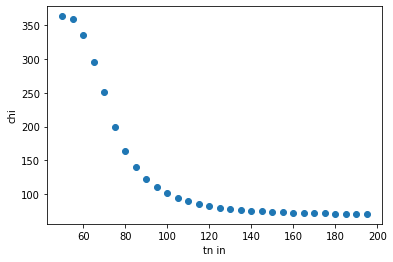

ORDER PARAM RESULT (X2): 262.38603110295503
THE JT RESULT {X0}: 0.4000000361740301
THE NF RESULT {X1}: 228.00302702243616
chisqds:  111.31297065945017
BUT ARE WE SURE?: 724.9226235165197


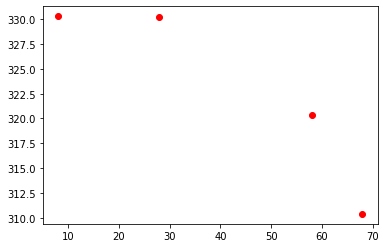

highHIIIIGHHHHHH:  272.0
rewaRD::  -100
stepping:  1
ACTION            :  4
curtemp:  88.0
Temperature:  [ 8. 28. 58. 68. 88.]
Intensity:  [330.3        330.21615139 320.37570572 310.38482635 277.33554063]


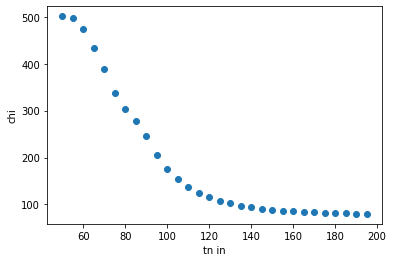

ORDER PARAM RESULT (X2): 231.401303954911
THE JT RESULT {X0}: 0.4000002988390911
THE NF RESULT {X1}: 235.46952390235256
chisqds:  51.22786186401293
BUT ARE WE SURE?: 41.976080722865866


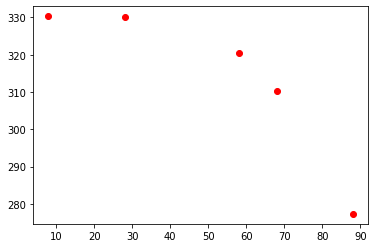

highHIIIIGHHHHHH:  252.0
rewaRD::  -100
stepping:  1
ACTION            :  4
curtemp:  108.0
Temperature:  [  8.  28.  58.  68.  88. 108.]
Intensity:  [330.3        330.21615139 320.37570572 310.38482635 277.33554063
 225.74443943]


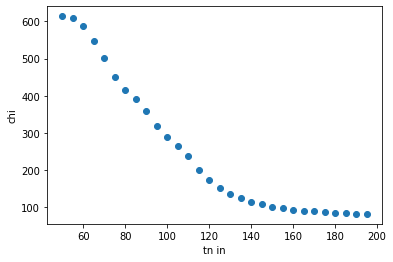

ORDER PARAM RESULT (X2): 196.7795373502601
THE JT RESULT {X0}: 0.4000004154725662
THE NF RESULT {X1}: 217.34710461678108
chisqds:  53.809099579056976
BUT ARE WE SURE?: 5.592227217669526


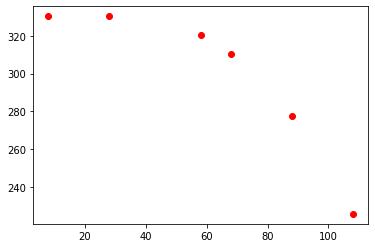

highHIIIIGHHHHHH:  232.0
rewaRD::  -100
stepping:  1
ACTION            :  5
curtemp:  133.0
Temperature:  [  8.  28.  58.  68.  88. 108. 133.]
Intensity:  [330.3        330.21615139 320.37570572 310.38482635 277.33554063
 225.74443943 134.08935162]


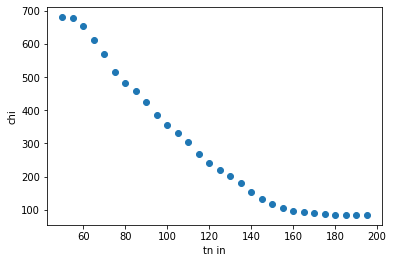

ORDER PARAM RESULT (X2): 159.9999999999996
THE JT RESULT {X0}: 0.8850000000000028
THE NF RESULT {X1}: 329.9999999999998
chisqds:  3.399940530318238e-27
BUT ARE WE SURE?: 0.7050586896787276


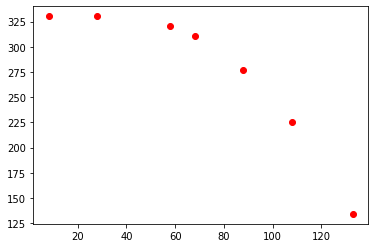

highHIIIIGHHHHHH:  207.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  2
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  2
ACTION            :  1
curtemp:  23.0
Temperature:  [18. 23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  2
ACTION            :  5
curtemp:  48.0
Temperature:  [18. 23. 48.]
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
stepping:  2
ACTION            :  3
curtemp:  63.0
Temperature:  [18. 23. 48. 63.]
Intensity:  [330.29946452 330.28840033 326.47253736 315.89652018]


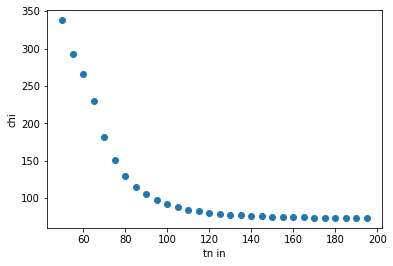

ORDER PARAM RESULT (X2): 279.2055044308235
THE JT RESULT {X0}: 0.4000001578946146
THE NF RESULT {X1}: 232.0915733147122
chisqds:  107.27278724873474
BUT ARE WE SURE?: 6328.881291154085


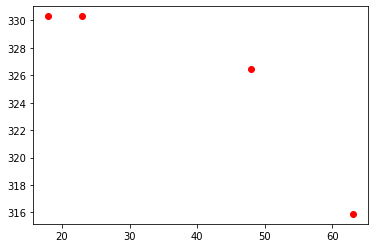

highHIIIIGHHHHHH:  277.0
rewaRD::  -100
stepping:  2
ACTION            :  1
curtemp:  68.0
Temperature:  [18. 23. 48. 63. 68.]
Intensity:  [330.29946452 330.28840033 326.47253736 315.89652018 310.38482635]


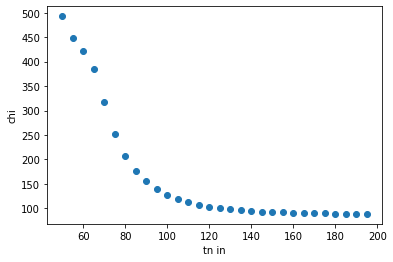

ORDER PARAM RESULT (X2): 263.7333561051989
THE JT RESULT {X0}: 0.400000119070206
THE NF RESULT {X1}: 231.74607530548704
chisqds:  64.00851280641814
BUT ARE WE SURE?: 761.9274908228952


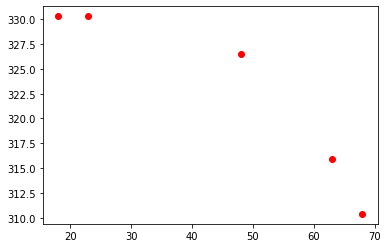

highHIIIIGHHHHHH:  272.0
rewaRD::  -100
stepping:  2
ACTION            :  0
curtemp:  69.0
Temperature:  [18. 23. 48. 63. 68. 69.]
Intensity:  [330.29946452 330.28840033 326.47253736 315.89652018 310.38482635
 309.1548429 ]


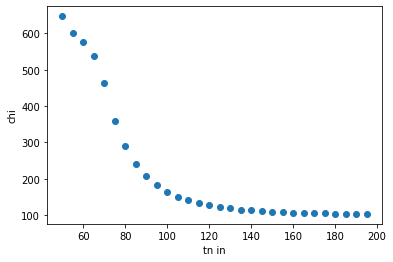

ORDER PARAM RESULT (X2): 258.9171632176578
THE JT RESULT {X0}: 0.40000031452834933
THE NF RESULT {X1}: 235.07946375809914
chisqds:  45.55384383779176
BUT ARE WE SURE?: 532.8495645699207


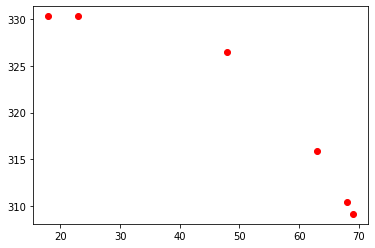

highHIIIIGHHHHHH:  271.0
rewaRD::  -100
stepping:  2
ACTION            :  4
curtemp:  89.0
Temperature:  [18. 23. 48. 63. 68. 69. 89.]
Intensity:  [330.29946452 330.28840033 326.47253736 315.89652018 310.38482635
 309.1548429  275.20424418]


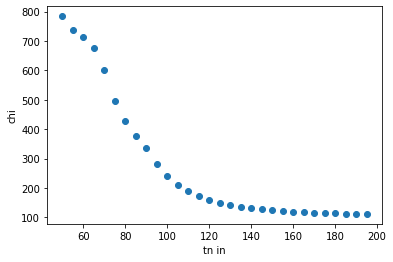

ORDER PARAM RESULT (X2): 203.6165693325986
THE JT RESULT {X0}: 0.4000011616738557
THE NF RESULT {X1}: 218.21661255192862
chisqds:  53.407126681949435
BUT ARE WE SURE?: 14.489685360628188


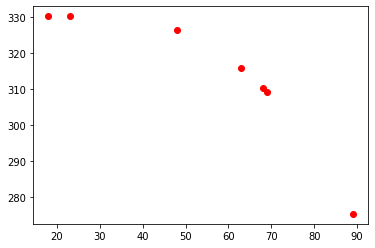

highHIIIIGHHHHHH:  251.0
rewaRD::  -100
stepping:  2
ACTION            :  0
curtemp:  90.0
Temperature:  [18. 23. 48. 63. 68. 69. 89. 90.]
Intensity:  [330.29946452 330.28840033 326.47253736 315.89652018 310.38482635
 309.1548429  275.20424418 273.02634585]


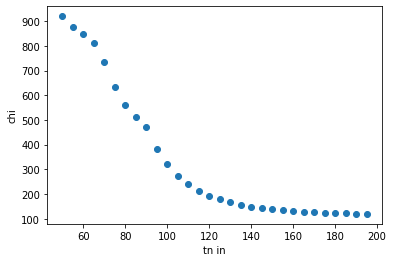

ORDER PARAM RESULT (X2): 201.8014121855874
THE JT RESULT {X0}: 0.4000000039653324
THE NF RESULT {X1}: 218.1289142804641
chisqds:  45.88577964288995
BUT ARE WE SURE?: 13.14515039740805


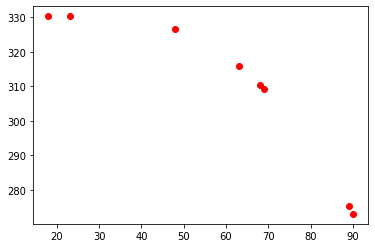

highHIIIIGHHHHHH:  250.0
rewaRD::  -100
stepping:  2
ACTION            :  6
curtemp:  120.0
Temperature:  [ 18.  23.  48.  63.  68.  69.  89.  90. 120.]
Intensity:  [330.29946452 330.28840033 326.47253736 315.89652018 310.38482635
 309.1548429  275.20424418 273.02634585 185.56995406]


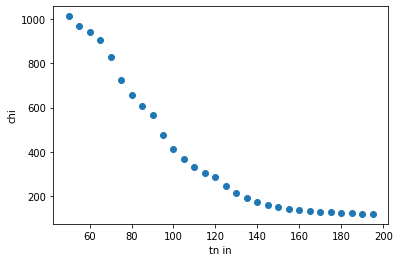

ORDER PARAM RESULT (X2): 197.2474698210201
THE JT RESULT {X0}: 0.40000013092294945
THE NF RESULT {X1}: 219.24186608436952
chisqds:  37.64613204007481
BUT ARE WE SURE?: 2.943857784025523


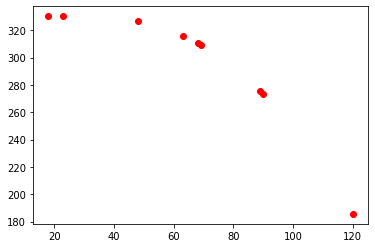

highHIIIIGHHHHHH:  220.0
rewaRD::  -100
stepping:  2
ACTION            :  4
curtemp:  140.0
Temperature:  [ 18.  23.  48.  63.  68.  69.  89.  90. 120. 140.]
Intensity:  [330.29946452 330.28840033 326.47253736 315.89652018 310.38482635
 309.1548429  275.20424418 273.02634585 185.56995406 102.90420164]


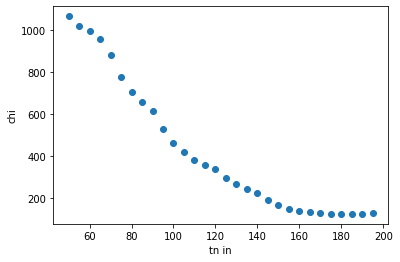

ORDER PARAM RESULT (X2): 160.00000000000333
THE JT RESULT {X0}: 0.8849999999999799
THE NF RESULT {X1}: 330.00000000000017
chisqds:  3.7881024018656975e-25
BUT ARE WE SURE?: 0.5574744661933041


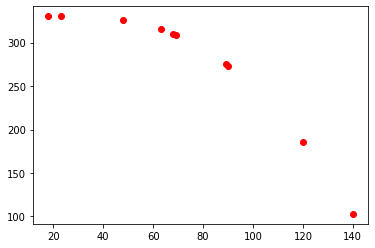

highHIIIIGHHHHHH:  200.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  3
ACTION            :  2
curtemp:  13.0
Temperature:  [13.]
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  3
ACTION            :  6
curtemp:  43.0
Temperature:  [13. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
stepping:  3
ACTION            :  6
curtemp:  73.0
Temperature:  [13. 43. 73.]
highHIIIIGHHHHHH:  267.0
rewaRD::  -100
stepping:  3
ACTION            :  0
curtemp:  74.0
Temperature:  [13. 43. 73. 74.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463]


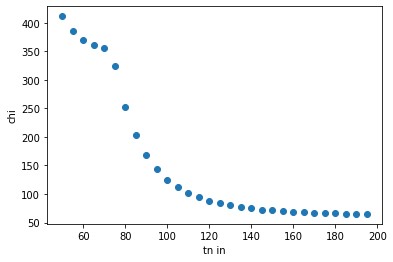

ORDER PARAM RESULT (X2): 243.73786482172457
THE JT RESULT {X0}: 0.4000001887381061
THE NF RESULT {X1}: 231.59843095406163
chisqds:  91.94754469892891
BUT ARE WE SURE?: 839.5448335609589


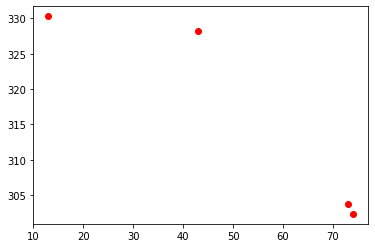

highHIIIIGHHHHHH:  266.0
rewaRD::  -100
stepping:  3
ACTION            :  1
curtemp:  79.0
Temperature:  [13. 43. 73. 74. 79.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463 294.44009001]


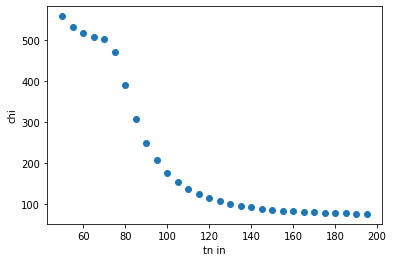

ORDER PARAM RESULT (X2): 239.9745092226627
THE JT RESULT {X0}: 0.40000040167788625
THE NF RESULT {X1}: 233.9536343632738
chisqds:  50.069662311693364
BUT ARE WE SURE?: 103.06069102894392


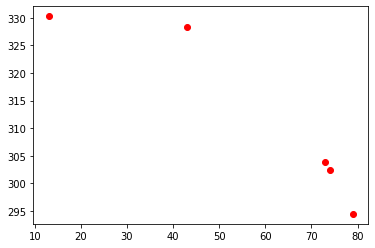

highHIIIIGHHHHHH:  261.0
rewaRD::  -100
stepping:  3
ACTION            :  1
curtemp:  84.0
Temperature:  [13. 43. 73. 74. 79. 84.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463 294.44009001
 285.39702198]


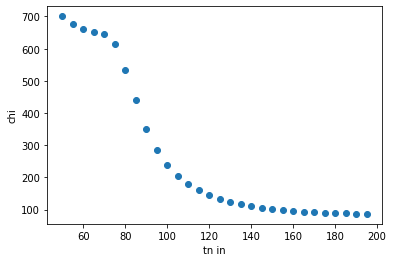

ORDER PARAM RESULT (X2): 235.89019829392242
THE JT RESULT {X0}: 0.40000007131803267
THE NF RESULT {X1}: 235.028704461067
chisqds:  35.84496194154746
BUT ARE WE SURE?: 45.362566153882746


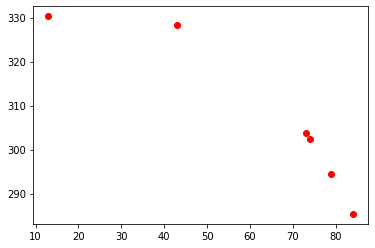

highHIIIIGHHHHHH:  256.0
rewaRD::  -100
stepping:  3
ACTION            :  3
curtemp:  99.0
Temperature:  [13. 43. 73. 74. 79. 84. 99.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463 294.44009001
 285.39702198 251.31117576]


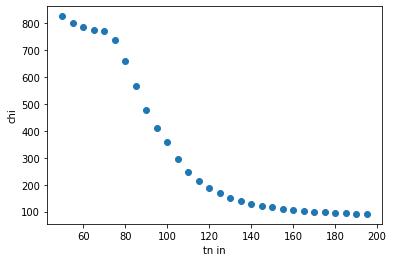

ORDER PARAM RESULT (X2): 197.3637602464931
THE JT RESULT {X0}: 0.40000035809531603
THE NF RESULT {X1}: 216.80835174230387
chisqds:  45.727042287262094
BUT ARE WE SURE?: 6.495347999473986


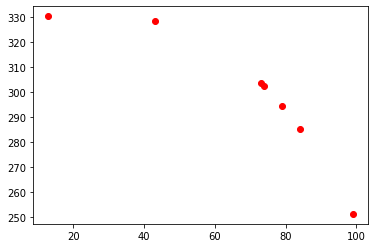

highHIIIIGHHHHHH:  241.0
rewaRD::  -100
stepping:  3
ACTION            :  0
curtemp:  100.0
Temperature:  [ 13.  43.  73.  74.  79.  84.  99. 100.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463 294.44009001
 285.39702198 251.31117576 248.66170242]


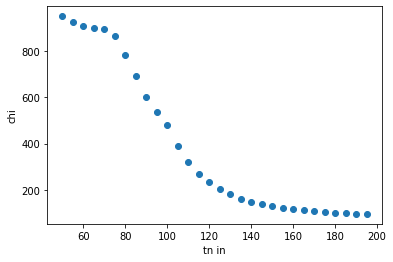

ORDER PARAM RESULT (X2): 197.04808240148273
THE JT RESULT {X0}: 0.40000124718501656
THE NF RESULT {X1}: 216.8637026911588
chisqds:  38.503418338629956
BUT ARE WE SURE?: 5.989031592288429


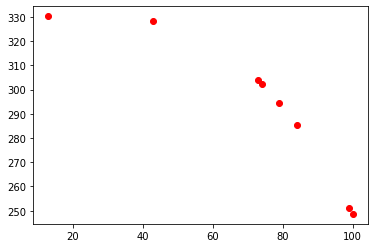

highHIIIIGHHHHHH:  240.0
rewaRD::  -100
stepping:  3
ACTION            :  0
curtemp:  101.0
Temperature:  [ 13.  43.  73.  74.  79.  84.  99. 100. 101.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463 294.44009001
 285.39702198 251.31117576 248.66170242 245.96462596]


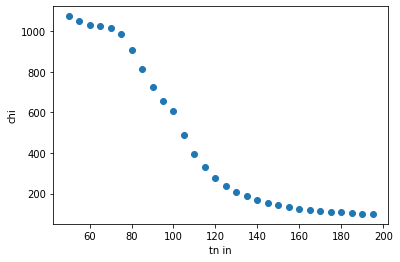

ORDER PARAM RESULT (X2): 197.04035011327622
THE JT RESULT {X0}: 0.4000000984494904
THE NF RESULT {X1}: 216.96654151727984
chisqds:  33.51506379707319
BUT ARE WE SURE?: 5.740798862782512


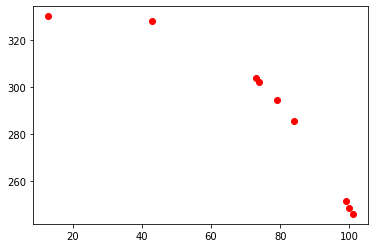

highHIIIIGHHHHHH:  239.0
rewaRD::  -100
stepping:  3
ACTION            :  6
curtemp:  131.0
Temperature:  [ 13.  43.  73.  74.  79.  84.  99. 100. 101. 131.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463 294.44009001
 285.39702198 251.31117576 248.66170242 245.96462596 142.55244007]


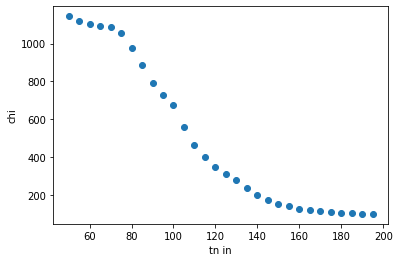

ORDER PARAM RESULT (X2): 197.35676420250488
THE JT RESULT {X0}: 0.4000001333207257
THE NF RESULT {X1}: 222.6616978225255
chisqds:  25.67594425265458
BUT ARE WE SURE?: 1.8282322346898683


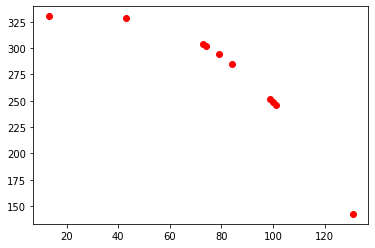

highHIIIIGHHHHHH:  209.0
rewaRD::  -100
stepping:  3
ACTION            :  1
curtemp:  136.0
Temperature:  [ 13.  43.  73.  74.  79.  84.  99. 100. 101. 131. 136.]
Intensity:  [330.29999768 328.26209554 303.80028204 302.35180463 294.44009001
 285.39702198 251.31117576 248.66170242 245.96462596 142.55244007
 121.0226225 ]


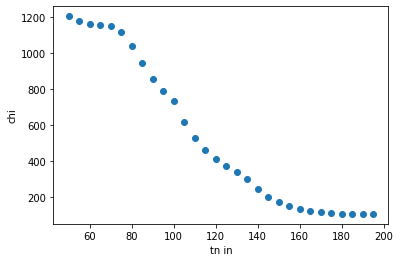

ORDER PARAM RESULT (X2): 159.99999999999613
THE JT RESULT {X0}: 0.8850000000000138
THE NF RESULT {X1}: 329.99999999999983
chisqds:  4.75820551712269e-25
BUT ARE WE SURE?: 0.5627506034776768


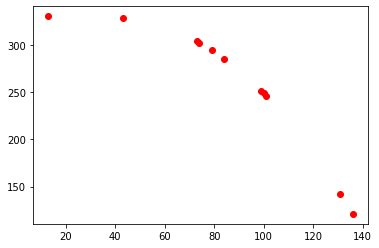

highHIIIIGHHHHHH:  204.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  4
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  4
ACTION            :  1
curtemp:  23.0
Temperature:  [18. 23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  4
ACTION            :  3
curtemp:  38.0
Temperature:  [18. 23. 38.]
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
stepping:  4
ACTION            :  0
curtemp:  39.0
Temperature:  [18. 23. 38. 39.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701]


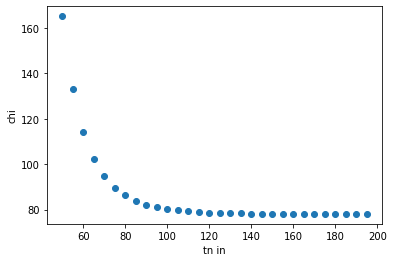

ORDER PARAM RESULT (X2): 319.3144542290768
THE JT RESULT {X0}: 0.4000000002038895
THE NF RESULT {X1}: 218.12652872016974
chisqds:  150.42240666171298
BUT ARE WE SURE?: 20264153.154938236


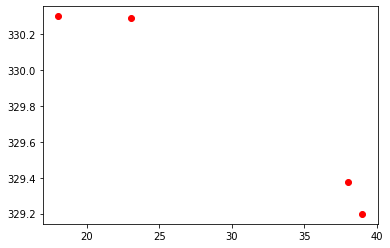

highHIIIIGHHHHHH:  301.0
rewaRD::  -100
stepping:  4
ACTION            :  6
curtemp:  69.0
Temperature:  [18. 23. 38. 39. 69.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701 309.1548429 ]


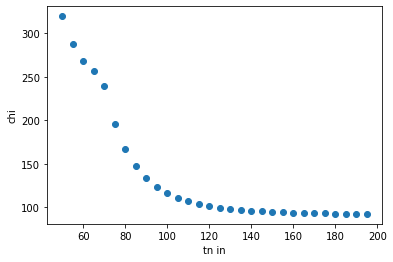

ORDER PARAM RESULT (X2): 255.43474208826365
THE JT RESULT {X0}: 0.400000003353302
THE NF RESULT {X1}: 233.27289464198955
chisqds:  65.48660990992097
BUT ARE WE SURE?: 11752.98133506109


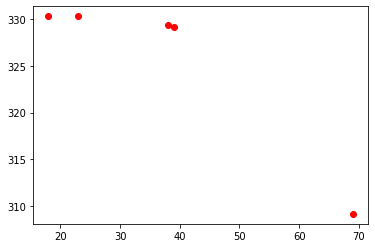

highHIIIIGHHHHHH:  271.0
rewaRD::  -100
stepping:  4
ACTION            :  1
curtemp:  74.0
Temperature:  [18. 23. 38. 39. 69. 74.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701 309.1548429
 302.35180463]


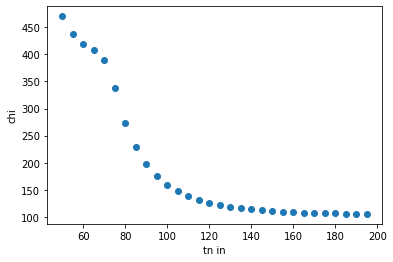

ORDER PARAM RESULT (X2): 216.96928616235823
THE JT RESULT {X0}: 0.40000000418408893
THE NF RESULT {X1}: 219.83645969398992
chisqds:  65.2499577610484
BUT ARE WE SURE?: 109.80181076096672


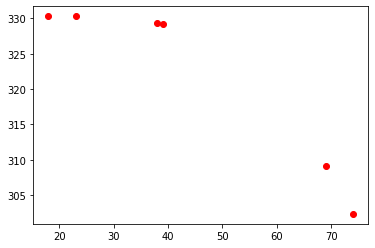

highHIIIIGHHHHHH:  266.0
rewaRD::  -100
stepping:  4
ACTION            :  2
curtemp:  84.0
Temperature:  [18. 23. 38. 39. 69. 74. 84.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701 309.1548429
 302.35180463 285.39702198]


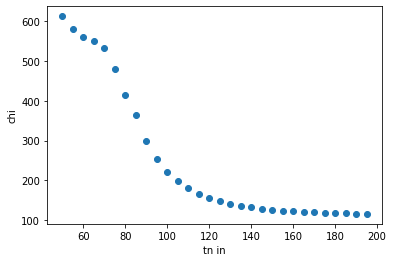

ORDER PARAM RESULT (X2): 207.90559153996062
THE JT RESULT {X0}: 0.4000004074491463
THE NF RESULT {X1}: 219.21823069146794
chisqds:  54.16553920630854
BUT ARE WE SURE?: 22.06616764515036


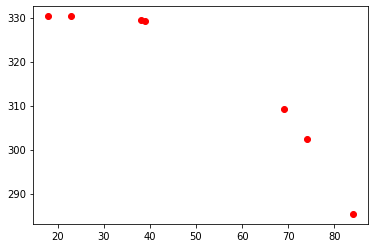

highHIIIIGHHHHHH:  256.0
rewaRD::  -100
stepping:  4
ACTION            :  2
curtemp:  94.0
Temperature:  [18. 23. 38. 39. 69. 74. 84. 94.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701 309.1548429
 302.35180463 285.39702198 263.84659791]


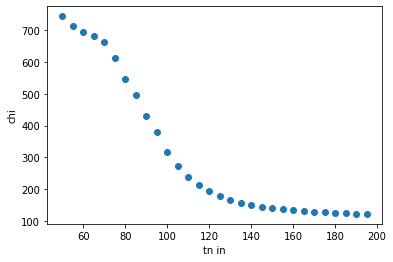

ORDER PARAM RESULT (X2): 202.77702848256797
THE JT RESULT {X0}: 0.40000008492804656
THE NF RESULT {X1}: 218.90300501052664
chisqds:  46.16956243976175
BUT ARE WE SURE?: 9.671378970334022


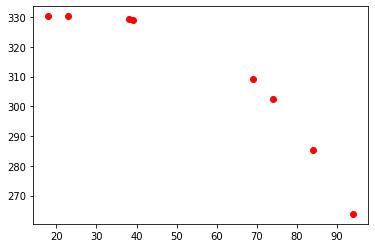

highHIIIIGHHHHHH:  246.0
rewaRD::  -100
stepping:  4
ACTION            :  4
curtemp:  114.0
Temperature:  [ 18.  23.  38.  39.  69.  74.  84.  94. 114.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701 309.1548429
 302.35180463 285.39702198 263.84659791 206.53244605]


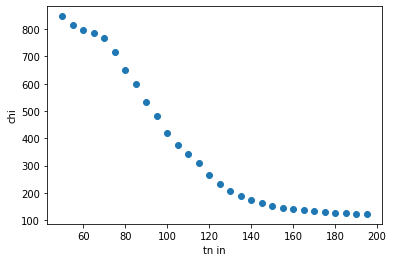

ORDER PARAM RESULT (X2): 198.47737913677543
THE JT RESULT {X0}: 0.4000001503312185
THE NF RESULT {X1}: 219.44225576941568
chisqds:  38.519993916442246
BUT ARE WE SURE?: 3.4022340709093966


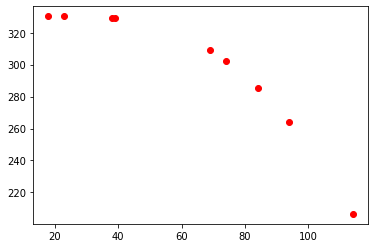

highHIIIIGHHHHHH:  226.0
rewaRD::  -100
stepping:  4
ACTION            :  0
curtemp:  115.0
Temperature:  [ 18.  23.  38.  39.  69.  74.  84.  94. 114. 115.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701 309.1548429
 302.35180463 285.39702198 263.84659791 206.53244605 203.16061113]


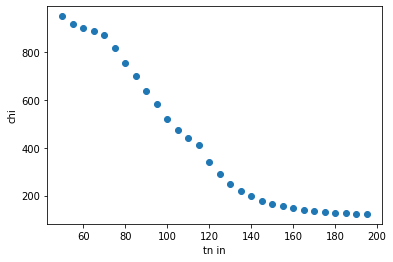

ORDER PARAM RESULT (X2): 197.84940684863565
THE JT RESULT {X0}: 0.4000001302353952
THE NF RESULT {X1}: 219.7765066801871
chisqds:  32.9879765109941
BUT ARE WE SURE?: 3.166579344749077


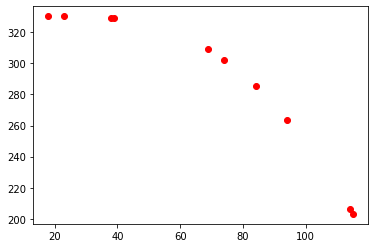

highHIIIIGHHHHHH:  225.0
rewaRD::  -100
stepping:  4
ACTION            :  6
curtemp:  145.0
Temperature:  [ 18.  23.  38.  39.  69.  74.  84.  94. 114. 115. 145.]
Intensity:  [330.29946452 330.28840033 329.37389335 329.19852701 309.1548429
 302.35180463 285.39702198 263.84659791 206.53244605 203.16061113
  79.13387604]


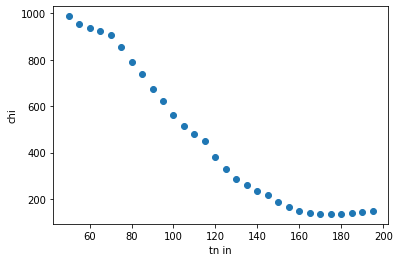

ORDER PARAM RESULT (X2): 159.9999999999948
THE JT RESULT {X0}: 0.8850000000000234
THE NF RESULT {X1}: 329.9999999999999
chisqds:  1.0709976139703641e-24
BUT ARE WE SURE?: 0.42069142038950513


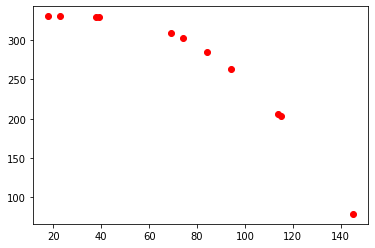

highHIIIIGHHHHHH:  195.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  5
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
stepping:  5
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
stepping:  5
ACTION            :  1
curtemp:  68.0
Temperature:  [33. 63. 68.]
highHIIIIGHHHHHH:  272.0
rewaRD::  -100
stepping:  5
ACTION            :  2
curtemp:  78.0
Temperature:  [33. 63. 68. 78.]
Intensity:  [329.96643649 315.89652018 310.38482635 296.11230154]


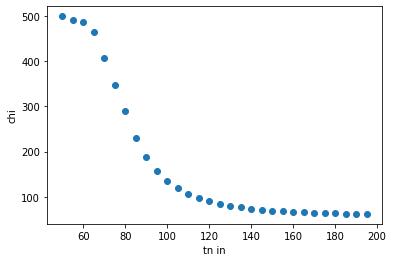

ORDER PARAM RESULT (X2): 243.17495371378496
THE JT RESULT {X0}: 0.40000006159809176
THE NF RESULT {X1}: 230.8538176839523
chisqds:  87.88796644756894
BUT ARE WE SURE?: 111.13858104372576


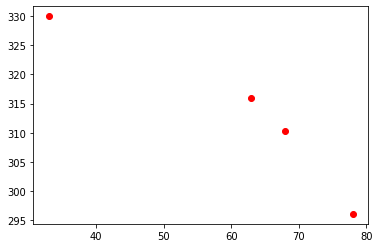

highHIIIIGHHHHHH:  262.0
rewaRD::  -100
stepping:  5
ACTION            :  3
curtemp:  93.0
Temperature:  [33. 63. 68. 78. 93.]
Intensity:  [329.96643649 315.89652018 310.38482635 296.11230154 266.21196364]


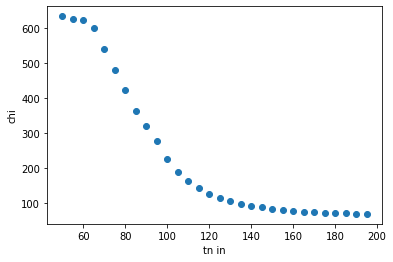

ORDER PARAM RESULT (X2): 229.17524939660532
THE JT RESULT {X0}: 0.4000004190918555
THE NF RESULT {X1}: 235.07890575974412
chisqds:  42.485103782532114
BUT ARE WE SURE?: 25.059554911407922


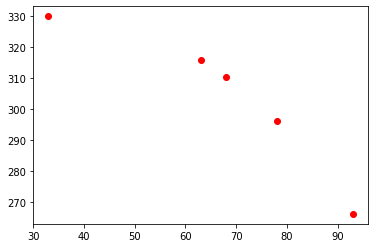

highHIIIIGHHHHHH:  247.0
rewaRD::  -100
stepping:  5
ACTION            :  4
curtemp:  113.0
Temperature:  [ 33.  63.  68.  78.  93. 113.]
Intensity:  [329.96643649 315.89652018 310.38482635 296.11230154 266.21196364
 209.85565285]


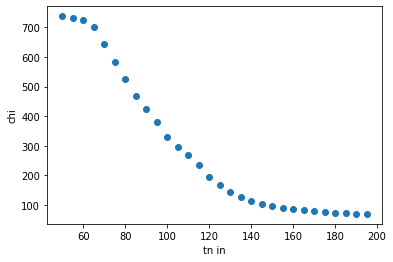

ORDER PARAM RESULT (X2): 196.07687046986337
THE JT RESULT {X0}: 0.40000002647276006
THE NF RESULT {X1}: 216.6355315924452
chisqds:  47.07715175589467
BUT ARE WE SURE?: 4.654688311823821


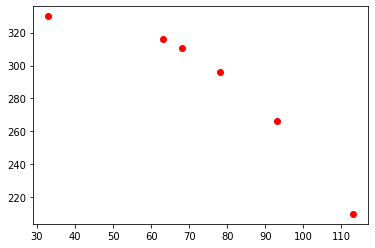

highHIIIIGHHHHHH:  227.0
rewaRD::  -100
stepping:  5
ACTION            :  4
curtemp:  133.0
Temperature:  [ 33.  63.  68.  78.  93. 113. 133.]
Intensity:  [329.96643649 315.89652018 310.38482635 296.11230154 266.21196364
 209.85565285 134.08935162]


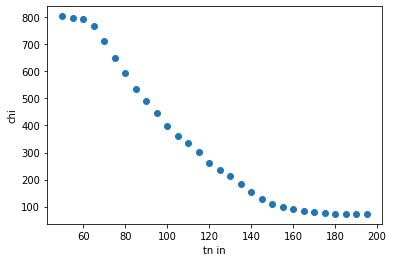

ORDER PARAM RESULT (X2): 194.60247708636587
THE JT RESULT {X0}: 0.4000000373189788
THE NF RESULT {X1}: 228.7692902578578
chisqds:  28.59673271516355
BUT ARE WE SURE?: 2.0518379664239794


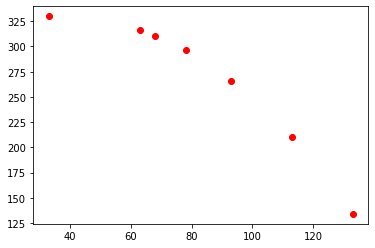

highHIIIIGHHHHHH:  207.0
rewaRD::  -100
stepping:  5
ACTION            :  1
curtemp:  138.0
Temperature:  [ 33.  63.  68.  78.  93. 113. 133. 138.]
Intensity:  [329.96643649 315.89652018 310.38482635 296.11230154 266.21196364
 209.85565285 134.08935162 112.06299387]


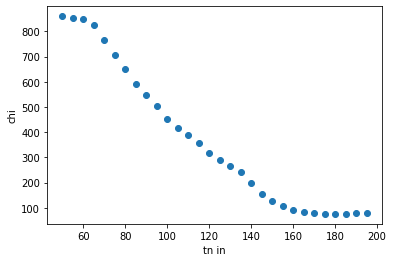

ORDER PARAM RESULT (X2): 159.99999999999892
THE JT RESULT {X0}: 0.8850000000000082
THE NF RESULT {X1}: 329.99999999999994
chisqds:  7.850166592752857e-26
BUT ARE WE SURE?: 0.7203844097472657


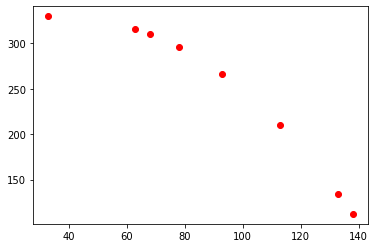

highHIIIIGHHHHHH:  202.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  6
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  6
ACTION            :  3
curtemp:  19.0
Temperature:  [ 4. 19.]
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
stepping:  6
ACTION            :  1
curtemp:  24.0
Temperature:  [ 4. 19. 24.]
highHIIIIGHHHHHH:  316.0
rewaRD::  -100
stepping:  6
ACTION            :  3
curtemp:  39.0
Temperature:  [ 4. 19. 24. 39.]
Intensity:  [330.3        330.29887253 330.28159928 329.19852701]


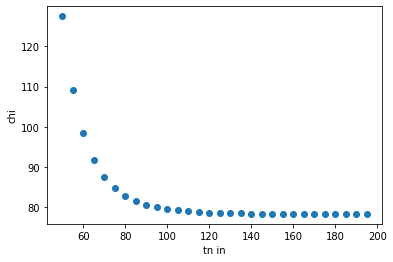

ORDER PARAM RESULT (X2): 159.99999999932848
THE JT RESULT {X0}: 0.8849999999866939
THE NF RESULT {X1}: 330.0
chisqds:  5.631639736344363e-26
BUT ARE WE SURE?: 1777.382948924224


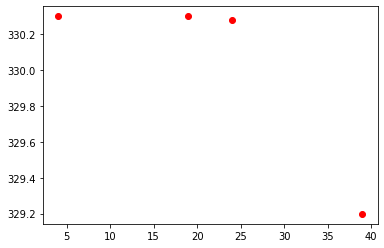

highHIIIIGHHHHHH:  301.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  7
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  7
ACTION            :  5
curtemp:  29.0
Temperature:  [ 4. 29.]
highHIIIIGHHHHHH:  311.0
rewaRD::  -100
stepping:  7
ACTION            :  6
curtemp:  59.0
Temperature:  [ 4. 29. 59.]
highHIIIIGHHHHHH:  281.0
rewaRD::  -100
stepping:  7
ACTION            :  1
curtemp:  64.0
Temperature:  [ 4. 29. 59. 64.]
Intensity:  [330.3        330.18522188 319.56010657 314.87824295]


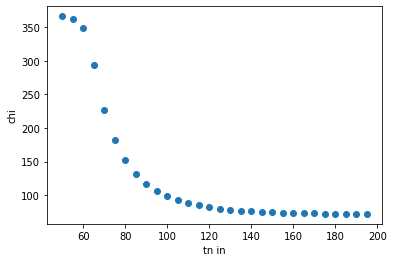

ORDER PARAM RESULT (X2): 273.24383313886653
THE JT RESULT {X0}: 0.4000000456016977
THE NF RESULT {X1}: 232.7802896403072
chisqds:  101.92102481112323
BUT ARE WE SURE?: 1806.255560535211


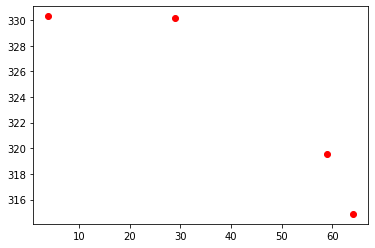

highHIIIIGHHHHHH:  276.0
rewaRD::  -100
stepping:  7
ACTION            :  5
curtemp:  89.0
Temperature:  [ 4. 29. 59. 64. 89.]
Intensity:  [330.3        330.18522188 319.56010657 314.87824295 275.20424418]


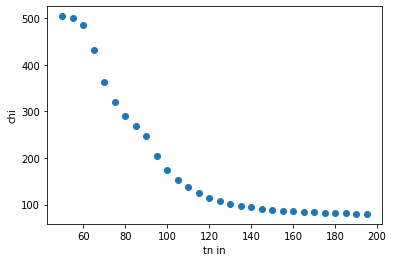

ORDER PARAM RESULT (X2): 230.2838778852688
THE JT RESULT {X0}: 0.4000002139262579
THE NF RESULT {X1}: 235.85300246932454
chisqds:  51.22647154033596
BUT ARE WE SURE?: 46.393074699711796


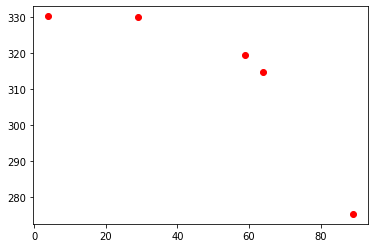

highHIIIIGHHHHHH:  251.0
rewaRD::  -100
stepping:  7
ACTION            :  3
curtemp:  104.0
Temperature:  [  4.  29.  59.  64.  89. 104.]
Intensity:  [330.3        330.18522188 319.56010657 314.87824295 275.20424418
 237.58672063]


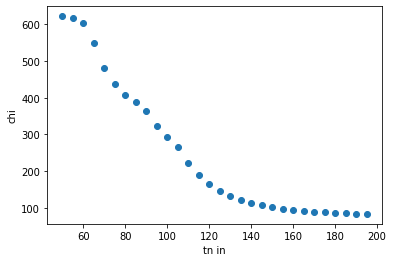

ORDER PARAM RESULT (X2): 197.21596959387432
THE JT RESULT {X0}: 0.4000003303204689
THE NF RESULT {X1}: 217.36710124342815
chisqds:  54.7799294047425
BUT ARE WE SURE?: 7.123622554479392


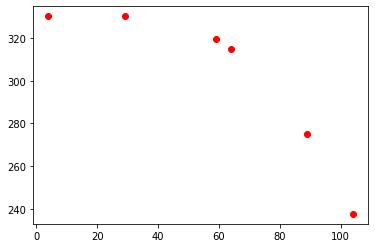

highHIIIIGHHHHHH:  236.0
rewaRD::  -100
stepping:  7
ACTION            :  6
curtemp:  134.0
Temperature:  [  4.  29.  59.  64.  89. 104. 134.]
Intensity:  [330.3        330.18522188 319.56010657 314.87824295 275.20424418
 237.58672063 129.78338311]


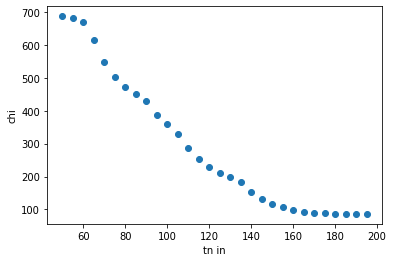

ORDER PARAM RESULT (X2): 160.00000000008242
THE JT RESULT {X0}: 0.8849999999998384
THE NF RESULT {X1}: 330.00000000000716
chisqds:  2.2198677190429114e-22
BUT ARE WE SURE?: 0.6849460689546835


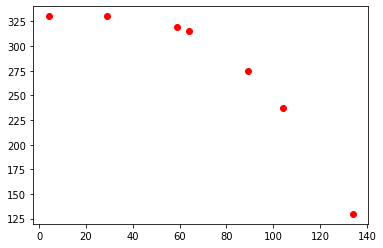

highHIIIIGHHHHHH:  206.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  8
ACTION            :  4
curtemp:  23.0
Temperature:  [23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  8
ACTION            :  2
curtemp:  33.0
Temperature:  [23. 33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
stepping:  8
ACTION            :  0
curtemp:  34.0
Temperature:  [23. 33. 34.]
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
stepping:  8
ACTION            :  1
curtemp:  39.0
Temperature:  [23. 33. 34. 39.]
Intensity:  [330.28840033 329.96643649 329.88107604 329.19852701]


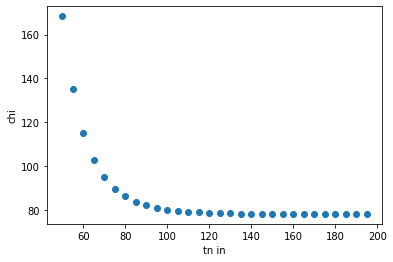

ORDER PARAM RESULT (X2): 340.95756192809847
THE JT RESULT {X0}: 0.4000000001118617
THE NF RESULT {X1}: 240.4192334095277
chisqds:  96.30863878290823
BUT ARE WE SURE?: 118958469.88461393


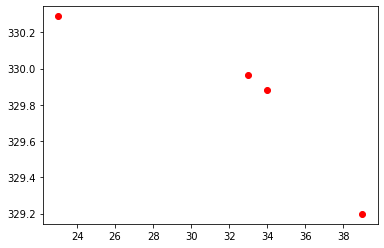

highHIIIIGHHHHHH:  301.0
rewaRD::  -100
stepping:  8
ACTION            :  6
curtemp:  69.0
Temperature:  [23. 33. 34. 39. 69.]
Intensity:  [330.28840033 329.96643649 329.88107604 329.19852701 309.1548429 ]


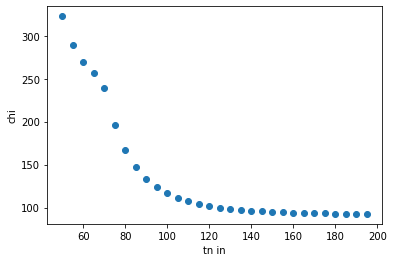

ORDER PARAM RESULT (X2): 255.11460508224985
THE JT RESULT {X0}: 0.40000021250059054
THE NF RESULT {X1}: 233.1806637965844
chisqds:  65.66098648186264
BUT ARE WE SURE?: 12910.790341115242


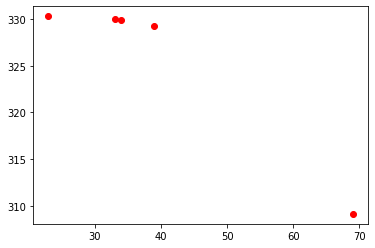

highHIIIIGHHHHHH:  271.0
rewaRD::  -100
stepping:  8
ACTION            :  6
curtemp:  99.0
Temperature:  [23. 33. 34. 39. 69. 99.]
Intensity:  [330.28840033 329.96643649 329.88107604 329.19852701 309.1548429
 251.31117576]


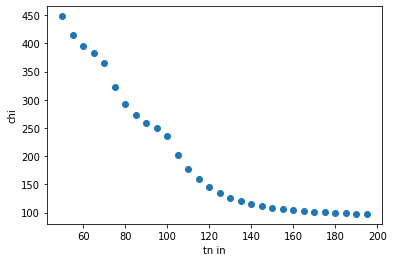

ORDER PARAM RESULT (X2): 201.90612301961517
THE JT RESULT {X0}: 0.4000002927211572
THE NF RESULT {X1}: 220.78410470478605
chisqds:  59.327174524446754
BUT ARE WE SURE?: 12.292439279361393


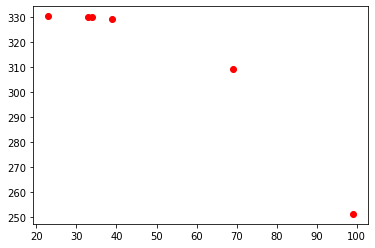

highHIIIIGHHHHHH:  241.0
rewaRD::  -100
stepping:  8
ACTION            :  2
curtemp:  109.0
Temperature:  [ 23.  33.  34.  39.  69.  99. 109.]
Intensity:  [330.28840033 329.96643649 329.88107604 329.19852701 309.1548429
 251.31117576 222.66343485]


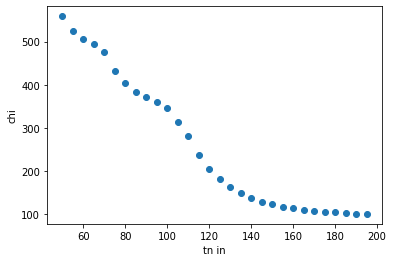

ORDER PARAM RESULT (X2): 198.696752141196
THE JT RESULT {X0}: 0.40000009962185973
THE NF RESULT {X1}: 219.90760674425482
chisqds:  46.2769637344187
BUT ARE WE SURE?: 6.359116275784969


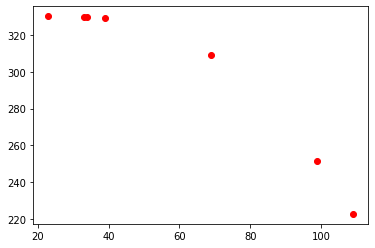

highHIIIIGHHHHHH:  231.0
rewaRD::  -100
stepping:  8
ACTION            :  2
curtemp:  119.0
Temperature:  [ 23.  33.  34.  39.  69.  99. 109. 119.]
Intensity:  [330.28840033 329.96643649 329.88107604 329.19852701 309.1548429
 251.31117576 222.66343485 189.18581439]


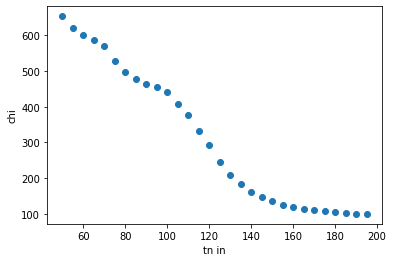

ORDER PARAM RESULT (X2): 197.35442819199275
THE JT RESULT {X0}: 0.4000000731289086
THE NF RESULT {X1}: 220.37352341648798
chisqds:  36.79275480639227
BUT ARE WE SURE?: 3.384384241613943


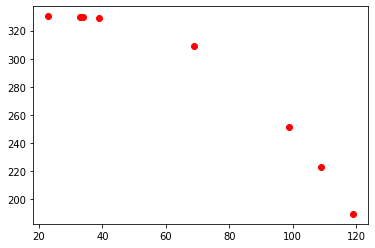

highHIIIIGHHHHHH:  221.0
rewaRD::  -100
stepping:  8
ACTION            :  0
curtemp:  120.0
Temperature:  [ 23.  33.  34.  39.  69.  99. 109. 119. 120.]
Intensity:  [330.28840033 329.96643649 329.88107604 329.19852701 309.1548429
 251.31117576 222.66343485 189.18581439 185.56995406]


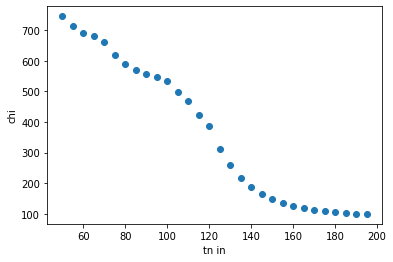

ORDER PARAM RESULT (X2): 197.0588003445747
THE JT RESULT {X0}: 0.4000000880292293
THE NF RESULT {X1}: 220.9536043736908
chisqds:  30.318468501175715
BUT ARE WE SURE?: 3.0190040514896586


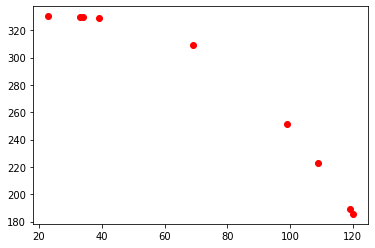

highHIIIIGHHHHHH:  220.0
rewaRD::  -100
stepping:  8
ACTION            :  4
curtemp:  140.0
Temperature:  [ 23.  33.  34.  39.  69.  99. 109. 119. 120. 140.]
Intensity:  [330.28840033 329.96643649 329.88107604 329.19852701 309.1548429
 251.31117576 222.66343485 189.18581439 185.56995406 102.90420164]


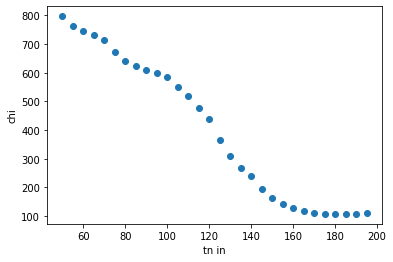

ORDER PARAM RESULT (X2): 160.00000000001262
THE JT RESULT {X0}: 0.8849999999999221
THE NF RESULT {X1}: 329.99999999999994
chisqds:  6.768757547594952e-24
BUT ARE WE SURE?: 0.4936555113645908


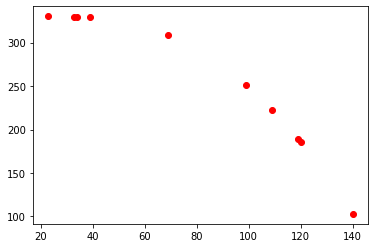

highHIIIIGHHHHHH:  200.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  9
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  9
ACTION            :  1
curtemp:  23.0
Temperature:  [18. 23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  9
ACTION            :  1
curtemp:  28.0
Temperature:  [18. 23. 28.]
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
stepping:  9
ACTION            :  0
curtemp:  29.0
Temperature:  [18. 23. 28. 29.]
Intensity:  [330.29946452 330.28840033 330.21615139 330.18522188]


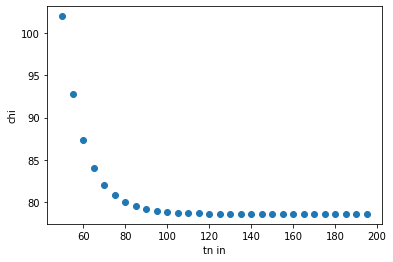

ORDER PARAM RESULT (X2): 232.49747176505056
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 216.00138754848115
chisqds:  157.26005398326126
BUT ARE WE SURE?: 1077009.568658312


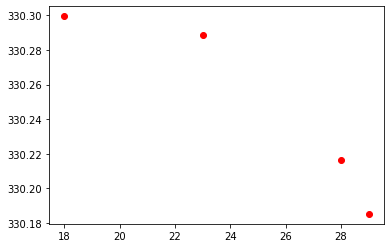

highHIIIIGHHHHHH:  311.0
rewaRD::  -100
stepping:  9
ACTION            :  0
curtemp:  30.0
Temperature:  [18. 23. 28. 29. 30.]
Intensity:  [330.29946452 330.28840033 330.21615139 330.18522188 330.1461209 ]


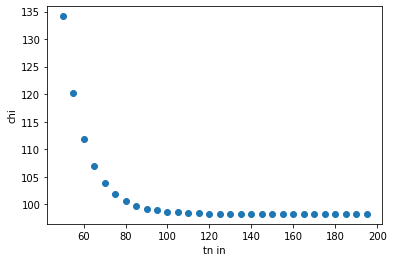

ORDER PARAM RESULT (X2): 221.23628188026728
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 216.0013772305759
chisqds:  98.25873907059993
BUT ARE WE SURE?: 660609.6756080803


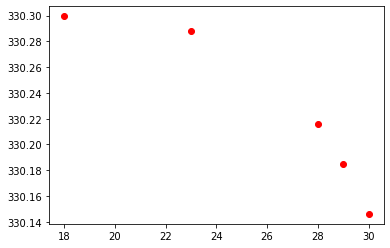

highHIIIIGHHHHHH:  310.0
rewaRD::  -100
stepping:  9
ACTION            :  4
curtemp:  50.0
Temperature:  [18. 23. 28. 29. 30. 50.]
Intensity:  [330.29946452 330.28840033 330.21615139 330.18522188 330.1461209
 325.53707578]


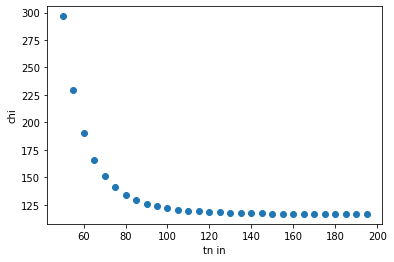

ORDER PARAM RESULT (X2): 399.9727156721597
THE JT RESULT {X0}: 1.8166548110635472
THE NF RESULT {X1}: 220.58663963189505
chisqds:  71.56340378617485
BUT ARE WE SURE?: 6414.131942973928


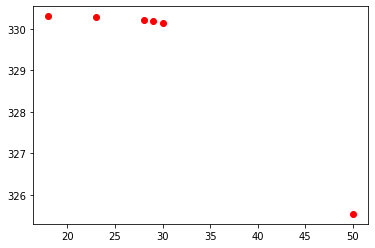

highHIIIIGHHHHHH:  290.0
rewaRD::  -100
stepping:  9
ACTION            :  5
curtemp:  75.0
Temperature:  [18. 23. 28. 29. 30. 50. 75.]
Intensity:  [330.29946452 330.28840033 330.21615139 330.18522188 330.1461209
 325.53707578 300.85896091]


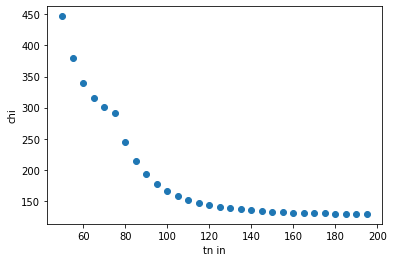

ORDER PARAM RESULT (X2): 225.00720494844393
THE JT RESULT {X0}: 0.4000005202888895
THE NF RESULT {X1}: 225.24280684563004
chisqds:  54.1195655792433
BUT ARE WE SURE?: 241.39412257124096


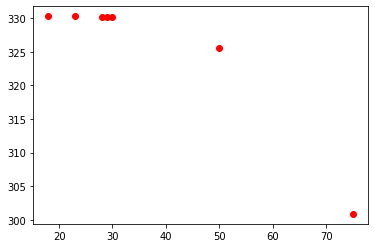

highHIIIIGHHHHHH:  265.0
rewaRD::  -100
stepping:  9
ACTION            :  5
curtemp:  100.0
Temperature:  [ 18.  23.  28.  29.  30.  50.  75. 100.]
Intensity:  [330.29946452 330.28840033 330.21615139 330.18522188 330.1461209
 325.53707578 300.85896091 248.66170242]


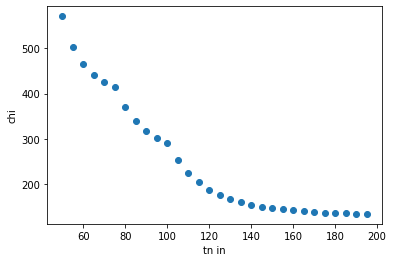

ORDER PARAM RESULT (X2): 205.44405612541325
THE JT RESULT {X0}: 0.4000001421432571
THE NF RESULT {X1}: 224.10690485977983
chisqds:  45.67265309961846
BUT ARE WE SURE?: 10.328298534701222


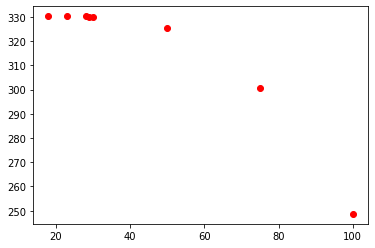

highHIIIIGHHHHHH:  240.0
rewaRD::  -100
stepping:  9
ACTION            :  6
curtemp:  130.0
Temperature:  [ 18.  23.  28.  29.  30.  50.  75. 100. 130.]
Intensity:  [330.29946452 330.28840033 330.21615139 330.18522188 330.1461209
 325.53707578 300.85896091 248.66170242 146.7097166 ]


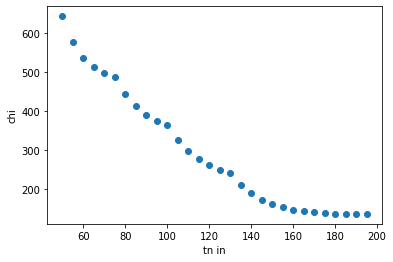

ORDER PARAM RESULT (X2): 159.99999999998872
THE JT RESULT {X0}: 0.8850000000000813
THE NF RESULT {X1}: 329.9999999999998
chisqds:  2.169912727351242e-24
BUT ARE WE SURE?: 0.7329215816237322


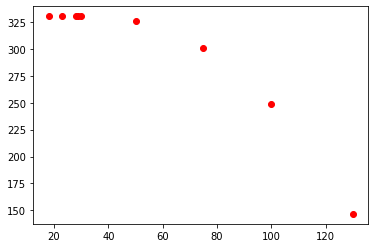

highHIIIIGHHHHHH:  210.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  10
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
stepping:  10
ACTION            :  2
curtemp:  43.0
Temperature:  [33. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
stepping:  10
ACTION            :  1
curtemp:  48.0
Temperature:  [33. 43. 48.]
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
stepping:  10
ACTION            :  0
curtemp:  49.0
Temperature:  [33. 43. 48. 49.]
Intensity:  [329.96643649 328.26209554 326.47253736 326.02142207]


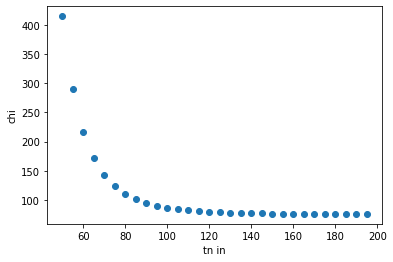

ORDER PARAM RESULT (X2): 399.9607128568196
THE JT RESULT {X0}: 1.3303189034122627
THE NF RESULT {X1}: 222.47633482360212
chisqds:  134.36262699538307
BUT ARE WE SURE?: 3826.5701391176117


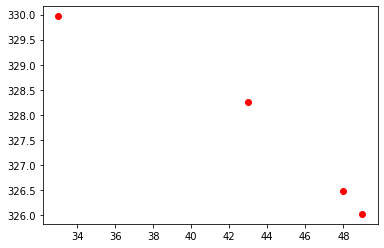

highHIIIIGHHHHHH:  291.0
rewaRD::  -100
stepping:  10
ACTION            :  1
curtemp:  54.0
Temperature:  [33. 43. 48. 49. 54.]
Intensity:  [329.96643649 328.26209554 326.47253736 326.02142207 323.25147787]


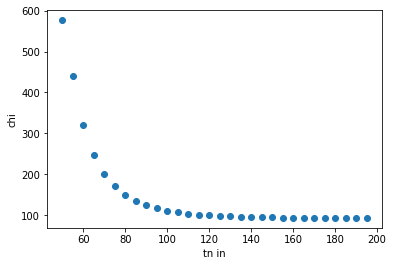

ORDER PARAM RESULT (X2): 292.03175315782914
THE JT RESULT {X0}: 1.9998972530020855
THE NF RESULT {X1}: 326.7011557704436
chisqds:  0.025814960011100306
BUT ARE WE SURE?: 1.161290101618651e-09


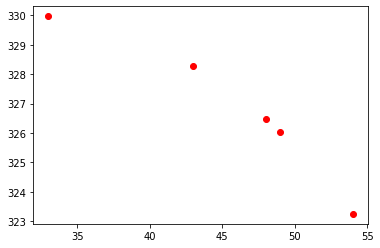

highHIIIIGHHHHHH:  286.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  11
ACTION            :  2
curtemp:  13.0
Temperature:  [13.]
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  11
ACTION            :  6
curtemp:  43.0
Temperature:  [13. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
stepping:  11
ACTION            :  2
curtemp:  53.0
Temperature:  [13. 43. 53.]
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
stepping:  11
ACTION            :  2
curtemp:  63.0
Temperature:  [13. 43. 53. 63.]
Intensity:  [330.29999768 328.26209554 323.87658773 315.89652018]


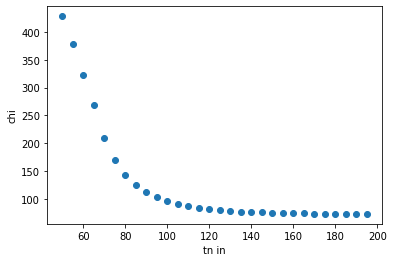

ORDER PARAM RESULT (X2): 284.47092777555713
THE JT RESULT {X0}: 0.4000000351134552
THE NF RESULT {X1}: 231.83639090922654
chisqds:  105.56327807825707
BUT ARE WE SURE?: 4141.9545604240675


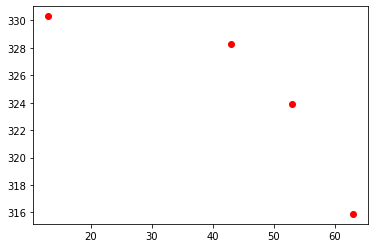

highHIIIIGHHHHHH:  277.0
rewaRD::  -100
stepping:  11
ACTION            :  5
curtemp:  88.0
Temperature:  [13. 43. 53. 63. 88.]
Intensity:  [330.29999768 328.26209554 323.87658773 315.89652018 277.33554063]


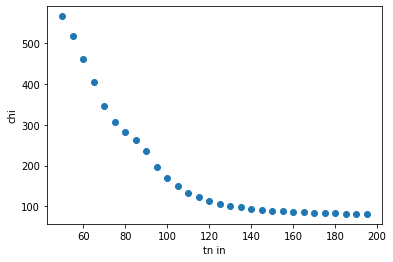

ORDER PARAM RESULT (X2): 230.33185358725416
THE JT RESULT {X0}: 0.400000423975946
THE NF RESULT {X1}: 234.95399174862973
chisqds:  53.323850043656016
BUT ARE WE SURE?: 57.189558293005234


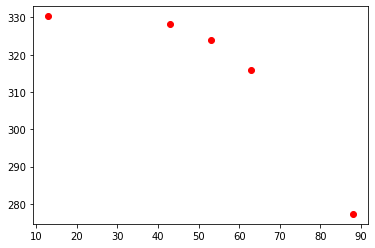

highHIIIIGHHHHHH:  252.0
rewaRD::  -100
stepping:  11
ACTION            :  6
curtemp:  118.0
Temperature:  [ 13.  43.  53.  63.  88. 118.]
Intensity:  [330.29999768 328.26209554 323.87658773 315.89652018 277.33554063
 192.75273721]


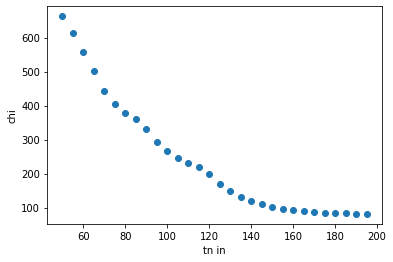

ORDER PARAM RESULT (X2): 196.32176368639077
THE JT RESULT {X0}: 0.4000000650655736
THE NF RESULT {X1}: 218.43191765553837
chisqds:  52.28217005851811
BUT ARE WE SURE?: 4.131264735062702


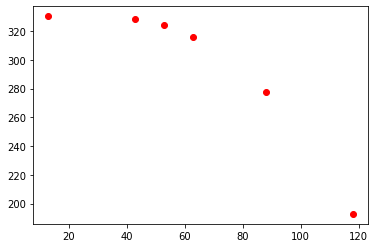

highHIIIIGHHHHHH:  222.0
rewaRD::  -100
stepping:  11
ACTION            :  2
curtemp:  128.0
Temperature:  [ 13.  43.  53.  63.  88. 118. 128.]
Intensity:  [330.29999768 328.26209554 323.87658773 315.89652018 277.33554063
 192.75273721 154.87594183]


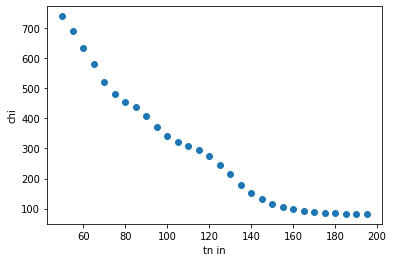

ORDER PARAM RESULT (X2): 160.0000000000061
THE JT RESULT {X0}: 0.8849999999999623
THE NF RESULT {X1}: 330.00000000000017
chisqds:  1.1554087869883073e-24
BUT ARE WE SURE?: 0.953248156755497


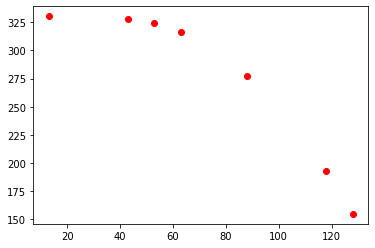

highHIIIIGHHHHHH:  212.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  12
ACTION            :  2
curtemp:  13.0
Temperature:  [13.]
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  12
ACTION            :  0
curtemp:  14.0
Temperature:  [13. 14.]
highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  12
ACTION            :  1
curtemp:  19.0
Temperature:  [13. 14. 19.]
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
stepping:  12
ACTION            :  5
curtemp:  44.0
Temperature:  [13. 14. 19. 44.]
Intensity:  [330.29999768 330.2999906  330.29887253 327.96297696]


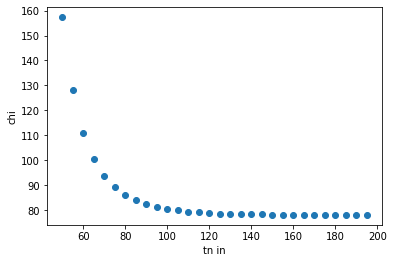

ORDER PARAM RESULT (X2): 159.99999999935352
THE JT RESULT {X0}: 0.8849999999885801
THE NF RESULT {X1}: 329.99999999999994
chisqds:  2.8895473523189565e-26
BUT ARE WE SURE?: 13372.739880611782


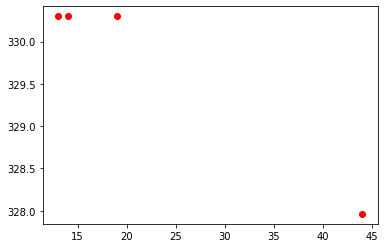

highHIIIIGHHHHHH:  296.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  13
ACTION            :  1
curtemp:  8.0
Temperature:  [8.]
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  13
ACTION            :  1
curtemp:  13.0
Temperature:  [ 8. 13.]
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  13
ACTION            :  3
curtemp:  28.0
Temperature:  [ 8. 13. 28.]
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
stepping:  13
ACTION            :  0
curtemp:  29.0
Temperature:  [ 8. 13. 28. 29.]
Intensity:  [330.3        330.29999768 330.21615139 330.18522188]


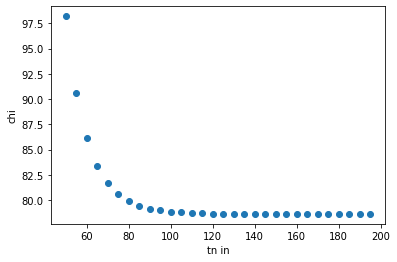

ORDER PARAM RESULT (X2): 231.97453714970504
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 216.00139228750422
chisqds:  157.2669717306323
BUT ARE WE SURE?: 1087753.6777604052


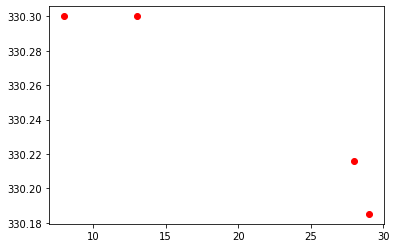

highHIIIIGHHHHHH:  311.0
rewaRD::  -100
stepping:  13
ACTION            :  1
curtemp:  34.0
Temperature:  [ 8. 13. 28. 29. 34.]
Intensity:  [330.3        330.29999768 330.21615139 330.18522188 329.88107604]


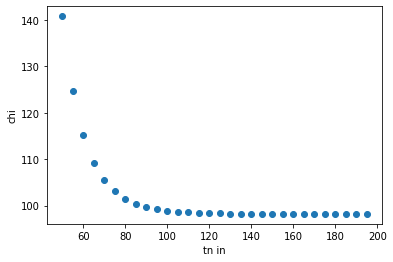

ORDER PARAM RESULT (X2): 159.999999999522
THE JT RESULT {X0}: 0.8849999999894532
THE NF RESULT {X1}: 329.9999999999999
chisqds:  1.7436891937980992e-26
BUT ARE WE SURE?: 775.4894150271789


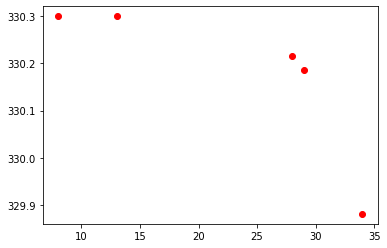

highHIIIIGHHHHHH:  306.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  14
ACTION            :  1
curtemp:  8.0
Temperature:  [8.]
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  14
ACTION            :  2
curtemp:  18.0
Temperature:  [ 8. 18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  14
ACTION            :  1
curtemp:  23.0
Temperature:  [ 8. 18. 23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  14
ACTION            :  4
curtemp:  43.0
Temperature:  [ 8. 18. 23. 43.]
Intensity:  [330.3        330.29946452 330.28840033 328.26209554]


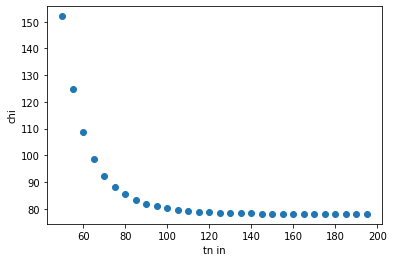

ORDER PARAM RESULT (X2): 159.99999999485232
THE JT RESULT {X0}: 0.8849999998809163
THE NF RESULT {X1}: 330.0
chisqds:  3.1629558150950765e-23
BUT ARE WE SURE?: 2013.469163441274


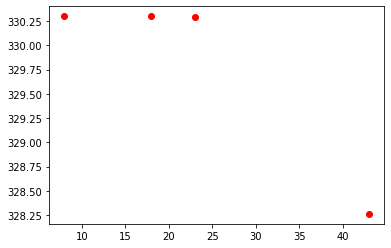

highHIIIIGHHHHHH:  297.0
rewaRD::  0
terminated: excellent conditions
reset
stepping:  15
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
stepping:  15
ACTION            :  0
curtemp:  34.0
Temperature:  [33. 34.]
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
stepping:  15
ACTION            :  3
curtemp:  49.0
Temperature:  [33. 34. 49.]
highHIIIIGHHHHHH:  291.0
rewaRD::  -100
stepping:  15
ACTION            :  3
curtemp:  64.0
Temperature:  [33. 34. 49. 64.]
Intensity:  [329.96643649 329.88107604 326.02142207 314.87824295]


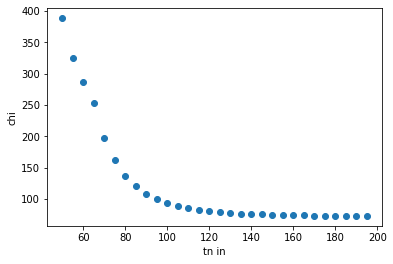

ORDER PARAM RESULT (X2): 274.2874762186033
THE JT RESULT {X0}: 0.4000000509876941
THE NF RESULT {X1}: 232.98242993960397
chisqds:  104.20716252921903
BUT ARE WE SURE?: 4076.1364109708315


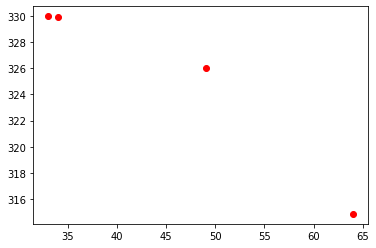

highHIIIIGHHHHHH:  276.0
rewaRD::  -100
stepping:  15
ACTION            :  2
curtemp:  74.0
Temperature:  [33. 34. 49. 64. 74.]
Intensity:  [329.96643649 329.88107604 326.02142207 314.87824295 302.35180463]


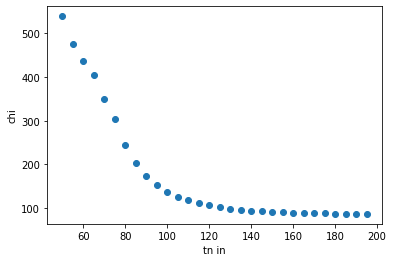

ORDER PARAM RESULT (X2): 249.68332712617675
THE JT RESULT {X0}: 0.4000001538912651
THE NF RESULT {X1}: 233.17544800700418
chisqds:  59.96971216176663
BUT ARE WE SURE?: 214.59465746240346


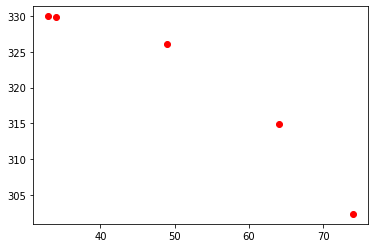

highHIIIIGHHHHHH:  266.0
rewaRD::  -100
stepping:  15
ACTION            :  4
curtemp:  94.0
Temperature:  [33. 34. 49. 64. 74. 94.]
Intensity:  [329.96643649 329.88107604 326.02142207 314.87824295 302.35180463
 263.84659791]


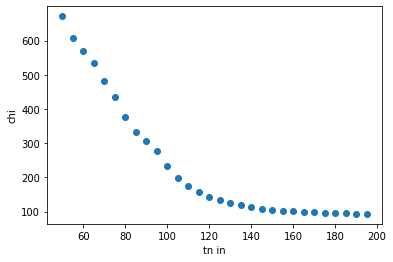

ORDER PARAM RESULT (X2): 200.15373617234206
THE JT RESULT {X0}: 0.4000001201509936
THE NF RESULT {X1}: 217.93149838876047
chisqds:  59.969948600189376
BUT ARE WE SURE?: 11.5328852803033


KeyboardInterrupt: ignored

In [19]:
# Train the agent
model = PPO2('MlpPolicy', env, verbose=1).learn(5000)

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

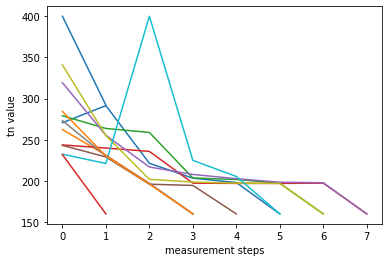

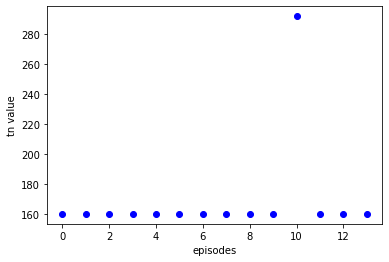

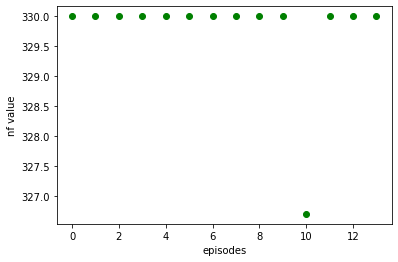

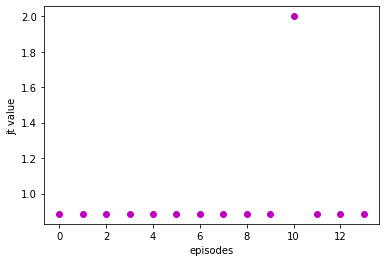

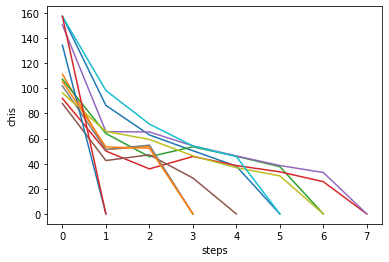

rewards at the end of the episode


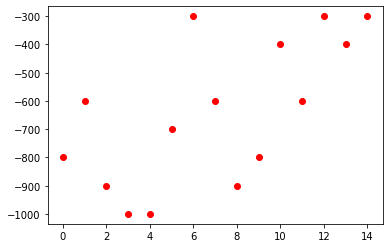

In [21]:
numTrials = 14

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
nfs = [[] for i in range(numTrials)]
jts = [[] for i in range(numTrials)]
endtns = []
endnfs = []
endjts = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
    data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".npy")
    chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".npy")
    nfs[i-1] = np.loadtxt(logstore + "nf/nfLog-" + str(i) + ".npy")
    jts[i-1] = np.loadtxt(logstore + "jt/jtLog-" + str(i) + ".npy")

#plot each episode tn track, process ending values for plotting below
for i in range (0, len(data)): 
    plt.plot(data[i], label = str(i))
    try:
      value = data[i][-1]
      nf = nfs[i][-1]
      jt = jts[i][-1]
      #endtns.append(data[i][-1])
    except:
      value = data[i]
      nf = nfs[i]
      jt = jts[i]
      #endtns.append(data[i])
    #print(value)
    endtns.append(value)
    endnfs.append(nf)
    endjts.append(jt)
    #print(endtns)

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "tns.png")
plt.close()



#actually plot final tn values for each episode
plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "endtns.png")
plt.close()

plt.plot(endnfs, 'go')
plt.xlabel("episodes")
plt.ylabel("nf value")
plt.show()
plt.savefig(imagestore + "endnfs.png")
plt.close()

plt.plot(endjts, 'mo')
plt.xlabel("episodes")
plt.ylabel("jt value")
plt.show()
plt.savefig(imagestore + "endjts.png")
plt.close()

#track chisq values through the episode
for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()



print("rewards at the end of the episode")
rewards = np.loadtxt('logs/runrewards.npy')
plt.plot(rewards, 'ro')
plt.show()
plt.close()


temperature:  [  3   7  11  15  19  23  27  31  35  39  43  47  51  55  59  63  67  71
  75  79  83  87  91  95  99 103 107 111 115 119 123 127 131 135 139 143
 147 151 155 159 163 167 171 175 179 183 187 191 195 199 203 207 211 215
 219 223 227 231 235 239 243 247 251 255 259 263 267 271 275 279 283 287
 291 295 299]
Intensity:  [430.3        430.3        430.29999993 430.29996838 430.29887253
 430.28840033 430.24014823 430.09753957 429.78058502 429.19852701
 428.26209554 426.89129874 425.01866925 422.58943412 419.56010657
 415.89652018 411.57186506 406.56497855 400.85896091 394.44009001
 387.29708067 379.42034799 370.80173638 361.43411578 351.31117576
 340.42721304 328.77720057 316.35642673 303.16061113 289.18581439
 274.42840034 258.88497973 242.55244007 225.42784731 207.50851196
 188.79189244 169.27566804 148.95761607 127.83570952 105.90802675
 100.3        100.3        100.3        100.3        100.3
 100.3        100.3        100.3        100.3        100.3
 100.3        100.3   

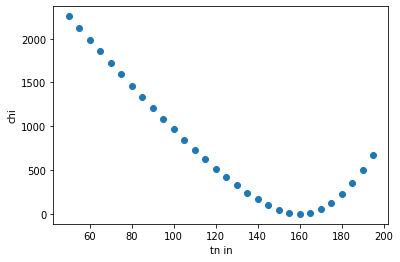

[160.]


In [ ]:
p=[.885,330,.3]
T=np.arange(3, 300, 4)
#T = np.array([14.5, 15])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 160,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Jt = p[0], Nf = p[1], Bk = p[2])
M.Tn.range(10,400)

x, dx, chisq, params = OrderMethods.fit(M)
print(x)

fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

plt.errorbar(T, I, error)
plt.plot(T, fitI,'ro', markersize = 2)
plt.xlabel("Temperature")
plt.ylabel("Intensity") 
plt.savefig("test")
plt.close()